In [ ]:
# Standard
import os
import sys
import datetime
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow.keras.backend as K
from tensorflow import argmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Utils
import h5py

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Note:** In this notebook, I did replication of https://github.com/albergcg/camus_challenge and I tried something different that I was curious about. I trained model step by step without data leakage.

If you encounter with any error, you can find the dataset from following links:

ready-to-use version of camus: https://www.kaggle.com/datasets/toygarr/camus-dataset<br/>
subject-based splitted version of camus: https://www.kaggle.com/datasets/toygarr/camus-subject-based<br/>
original dataset: https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8

In [ ]:
f = h5py.File("image_dataset.hdf5", "r")

In [ ]:
frames2ch = f["train 2ch frames"][:,:,:,:]
masks2ch = f["train 2ch masks"][:,:,:,:]

In [ ]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

# Metrics

In [ ]:

def multiclass_dice(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_lv(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:2])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:2])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_la(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,3:4])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,3:4])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_myo(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,2:3])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,2:3])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

# Loss Funct

In [ ]:
def generalized_dice_loss(y_true, y_pred, smooth=1e-7, num_classes=4):

    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return 1.0-K.mean((2. * intersect / (denom + smooth)))

# LadderNet Implementation

In [ ]:
drop = 0.25

def ResBlock(input_tensor, filters):
    """"
    Define Residual Block showed in Zhuang (2019)
    CONV => BATCH => RELU => DROPOUT => CONV => BATCH
      |                                   |
      |----------- SHARED LAYER ----------|

    """

    conv_1 = Conv2D(filters = filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')
    conv_1a = conv_1(input_tensor) # Shared weights conv layer
    batch_1 = BatchNormalization()(conv_1a)
    relu_1  = Activation("relu")(batch_1)
    drop_1  = Dropout(drop)(relu_1)
    conv_1b = conv_1(drop_1) # Shared weights conv layer
    batch_1 = BatchNormalization()(conv_1b)
    return batch_1

def LadderNet(input_size = (256, 256, 1), num_classes=2, filters=30):

    """
    LadderNet (Zhuang, 2019) implementation in tensorflow.keras
    Method: Keras Functional API
    """

    # X's denote standard flow
    # XNUM denote ResBlock outputs

    # "First" UNet

    # Input branch
    inputs = Input(input_size)
    X = Conv2D(filters=filters, kernel_size=3, activation="relu", padding = 'same', kernel_initializer = 'he_normal')(inputs)

    # Down branch
    X1 = ResBlock(input_tensor=X, filters=filters) # ResBlock located in the first layer of the paper scheme
    X = Conv2D(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X1)
    X = Activation("relu")(X) # This ReLU is not shown in the paper scheme

    X2 = ResBlock(input_tensor=X, filters=filters*2)
    X = Conv2D(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X2)
    X = Activation("relu")(X)

    X3 = ResBlock(input_tensor=X, filters=filters*4)
    X = Conv2D(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X3)
    X = Activation("relu")(X)

    X4 = ResBlock(input_tensor=X, filters=filters*8)
    X = Conv2D(filters=filters*16, kernel_size=3, strides=2, kernel_initializer='he_normal')(X4)
    X = Activation("relu")(X)

    # Bottom block
    X = ResBlock(input_tensor=X, filters=filters*16)

    # Up branch
    X = Conv2DTranspose(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X4])
    # X = Activation("relu")(X) # This ReLU is commented in the paper code
    X5 = ResBlock(input_tensor=X, filters=filters*8)

    X = Conv2DTranspose(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X5)
    X = Add()([X, X3])
    # X = Activation("relu")(X)
    X6 = ResBlock(input_tensor=X, filters=filters*4)

    X = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X6)
    X = Add()([X, X2])
    # X = Activation("relu")(X)
    X7 = ResBlock(input_tensor=X, filters=filters*2)

    X = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, output_padding=1, kernel_initializer='he_normal')(X7)
    X = Add()([X, X1])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters)

    # Top block (bottle-neck)
    X8 = ResBlock(input_tensor=X, filters=filters)
    X = ResBlock(input_tensor=X, filters=filters)
    X = Add()([X, X8])

    # "Second" UNet

    # Down branch
    X9 = ResBlock(input_tensor=X, filters=filters)
    X = Conv2D(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X7, X])

    X10 = ResBlock(input_tensor=X, filters=filters*2)
    X = Conv2D(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X6, X])

    X11 = ResBlock(input_tensor=X, filters=filters*4)
    X = Conv2D(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X5, X])

    X12 = ResBlock(input_tensor=X, filters=filters*8)
    X = Conv2D(filters=filters*16, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)

    # Bottom block
    X = ResBlock(input_tensor=X, filters=filters*16)

    # Up branch
    X = Conv2DTranspose(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X12])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*8)

    X = Conv2DTranspose(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X11])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*4)

    X = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X10])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*2)

    X = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, kernel_initializer='he_normal', output_padding=1)(X)
    X = Add()([X, X9])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters)

    # Final block
    X = Conv2D(filters=num_classes, kernel_size=1, kernel_initializer='he_normal')(X)
    # X = Activation("relu")(X)
    X = Activation("softmax")(X)
    #X = Conv2D(1, 1)(X)

    model = Model(inputs, X)

    return model

In [ ]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)

In [ ]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [ ]:
model_laddernet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 20  200         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 384, 384, 20  3620        ['conv2d[0][0]',                 
                                )                                 'dropout[0][0]']            

In [ ]:
model_laddernet.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

In [ ]:
history = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=50,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/50


2023-05-19 07:26:51.542157: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 79s 360ms/step - loss: 0.5994 - multiclass_dice: 0.5711 - accuracy: 0.8213 - val_loss: 18.5976 - val_multiclass_dice: 0.2731 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 49s 365ms/step - loss: 0.2758 - multiclass_dice: 0.7390 - accuracy: 0.9066 - val_loss: 0.7443 - val_multiclass_dice: 0.6328 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 47s 347ms/step - loss: 0.2231 - multiclass_dice: 0.7800 - accuracy: 0.9197 - val_loss: 21.0571 - val_multiclass_dice: 0.3433 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 49s 365ms/step - loss: 0.1945 - multiclass_dice: 0.8033 - accuracy: 0.9279 - val_loss: 0.2223 - val_multiclass_dice: 0.8024 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 47s 347ms/step - loss: 0.1726 - multiclass_dice: 0.8198 - accuracy: 0.9334 - val_loss: 0.2392 - val

1/1 [==============================] - 0s 25ms/step


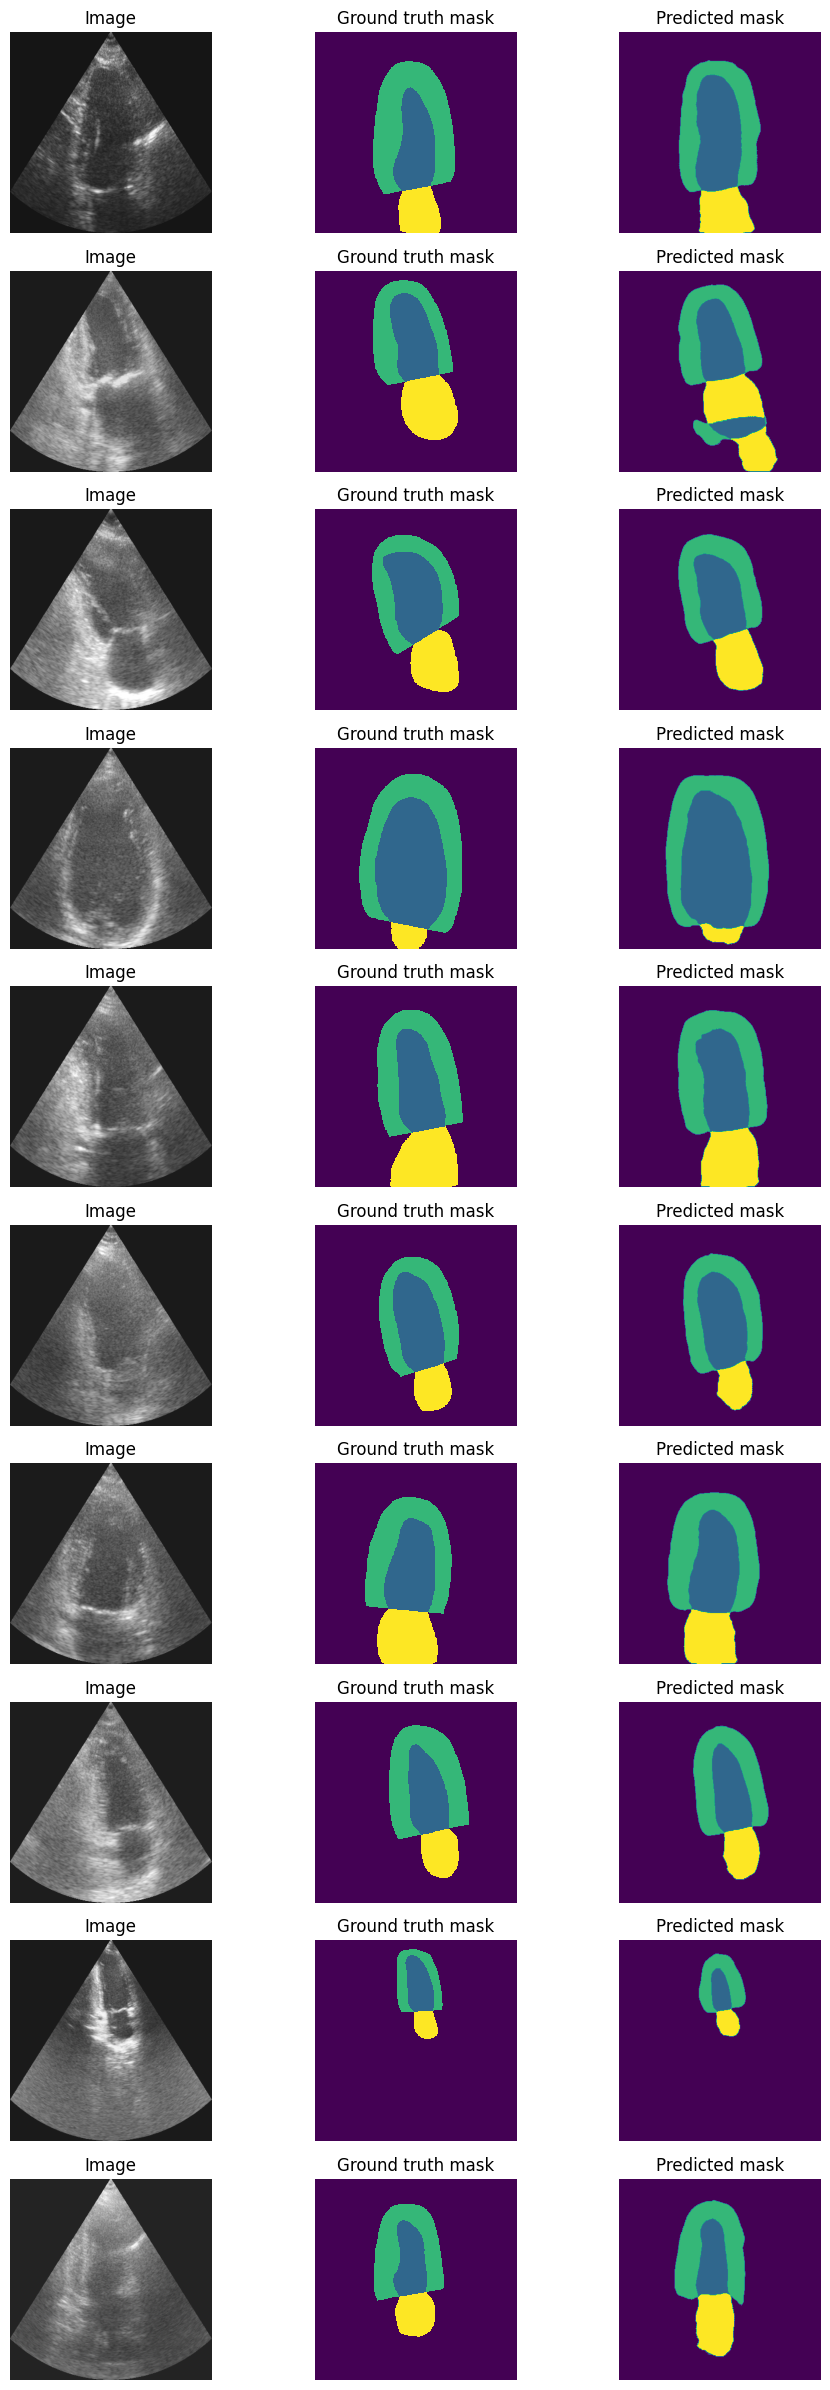

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 10
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(10):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


predicted_masks = []
for i in range(10):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

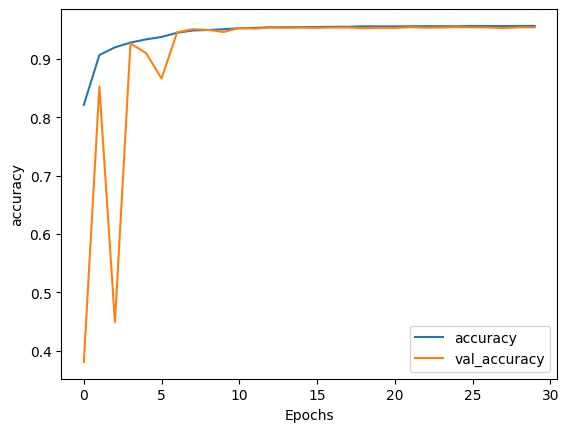

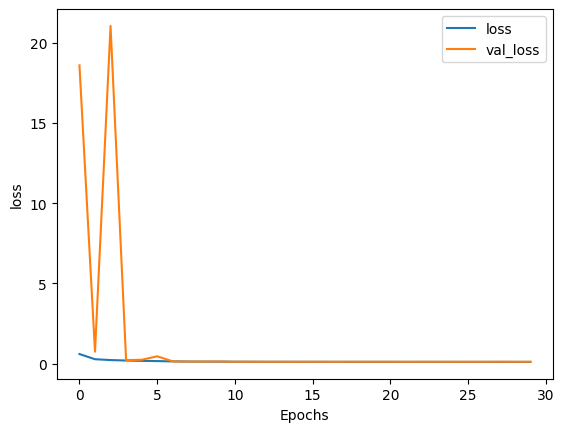

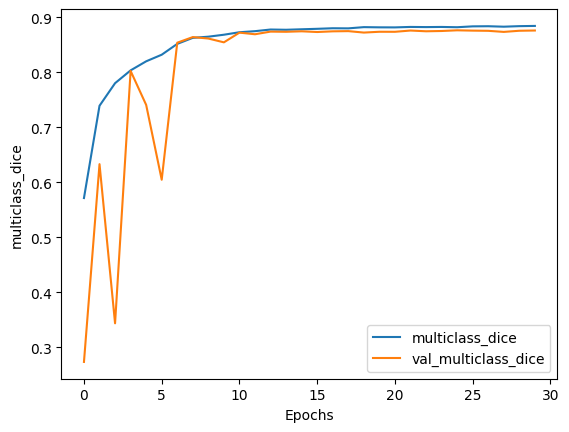

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "multiclass_dice")

# For 4ch

In [ ]:
frames4ch = f["train 4ch frames"][:,:,:,:]
masks4ch = f["train 4ch masks"][:,:,:,:]

In [ ]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames4ch, masks4ch)

In [ ]:
train_frames.shape

(675, 384, 384, 1)

In [ ]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)

In [ ]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [ ]:
model_laddernet.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

history = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=50,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/50


2023-05-19 13:54:05.591344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 80s 358ms/step - loss: 0.8735 - multiclass_dice: 0.4053 - accuracy: 0.7194 - val_loss: 26.2520 - val_multiclass_dice: 0.1998 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 47s 347ms/step - loss: 0.3101 - multiclass_dice: 0.6677 - accuracy: 0.8961 - val_loss: 12.5674 - val_multiclass_dice: 0.3652 - val_accuracy: 0.4197 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 49s 365ms/step - loss: 0.2239 - multiclass_dice: 0.7564 - accuracy: 0.9201 - val_loss: 0.4083 - val_multiclass_dice: 0.7317 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 49s 365ms/step - loss: 0.1884 - multiclass_dice: 0.7861 - accuracy: 0.9294 - val_loss: 0.4045 - val_multiclass_dice: 0.7361 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 47s 347ms/step - loss: 0.1699 - multiclass_dice: 0.8074 - accuracy: 0.9356 - val_loss: 0.2773 - val

1/1 [==============================] - 0s 25ms/step


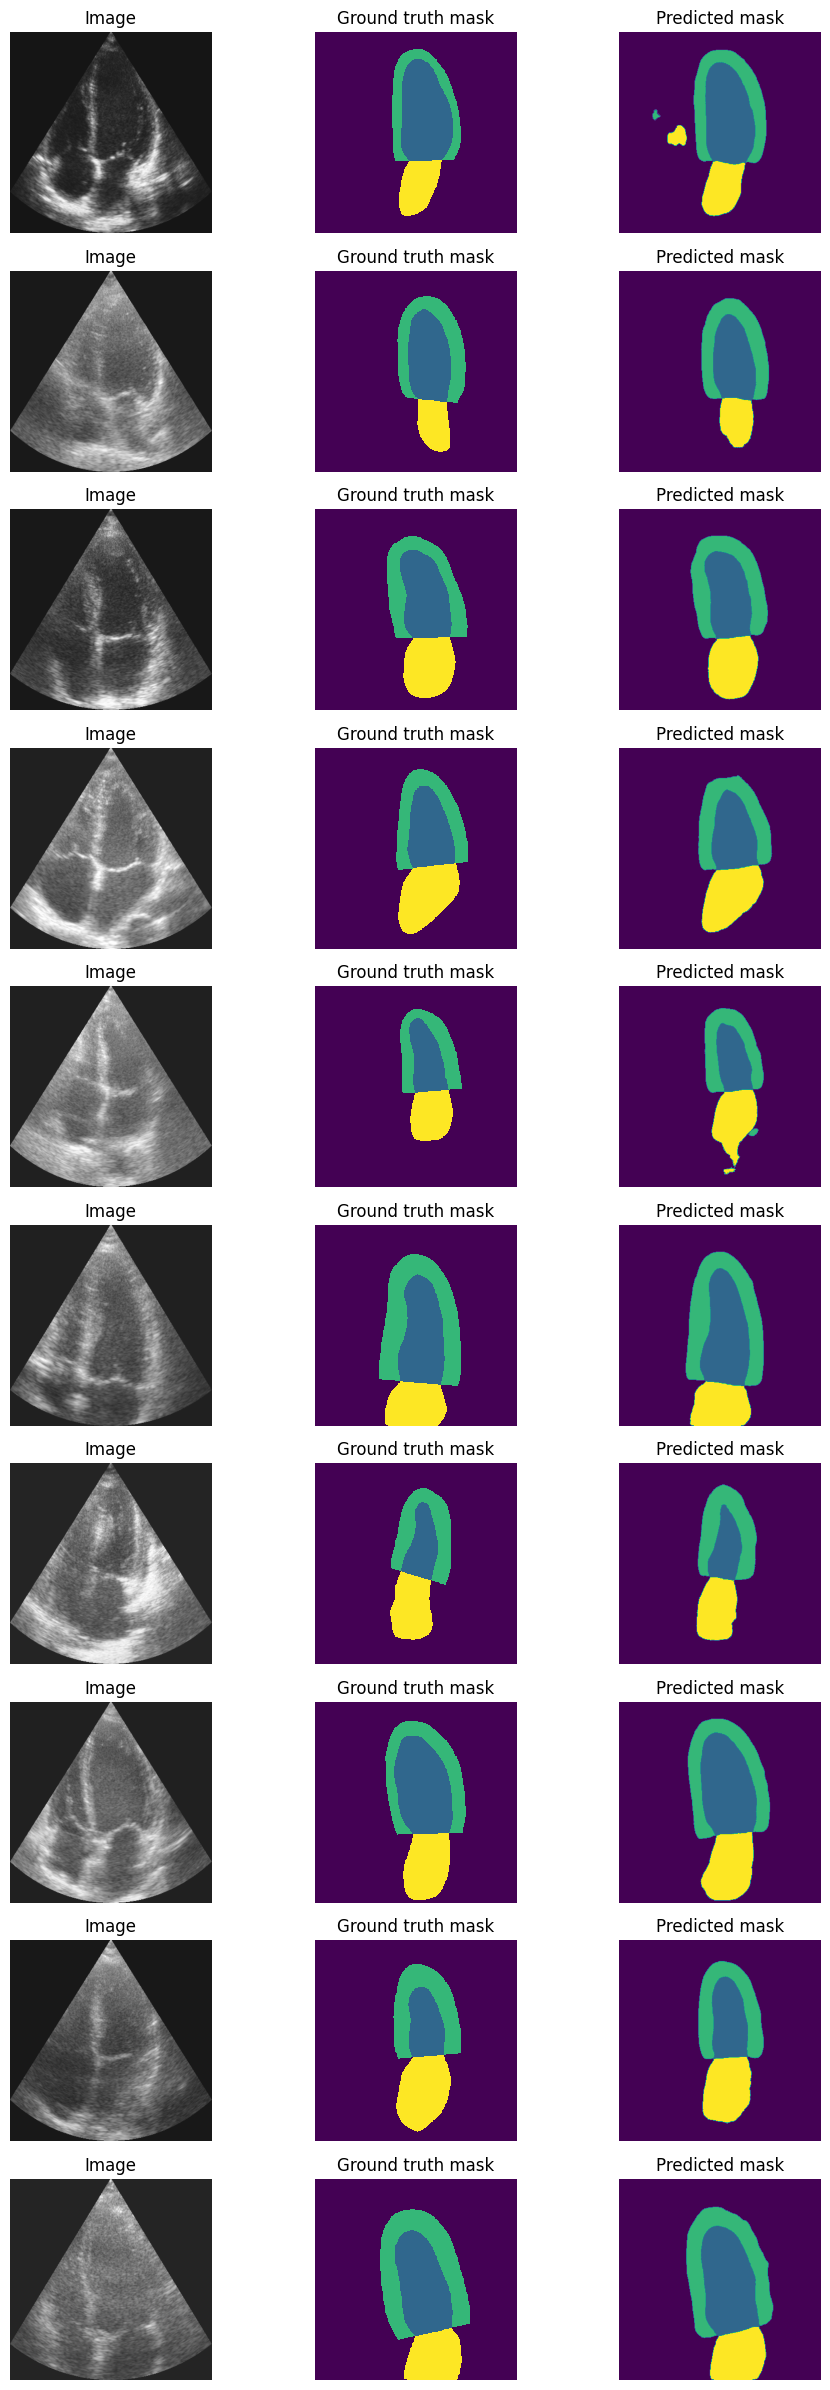

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 10
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(10):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


predicted_masks = []
for i in range(10):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

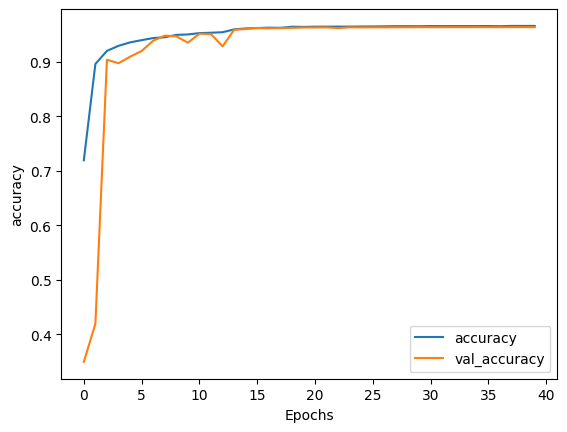

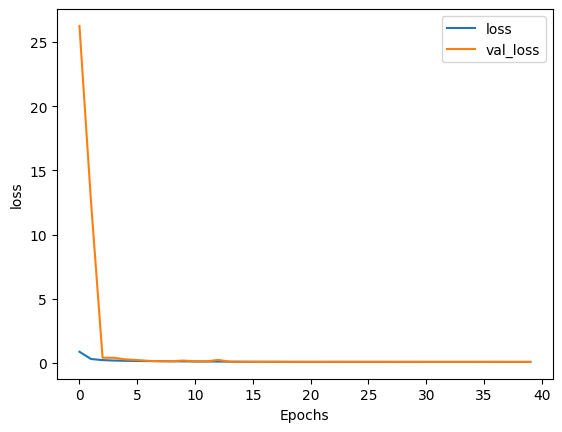

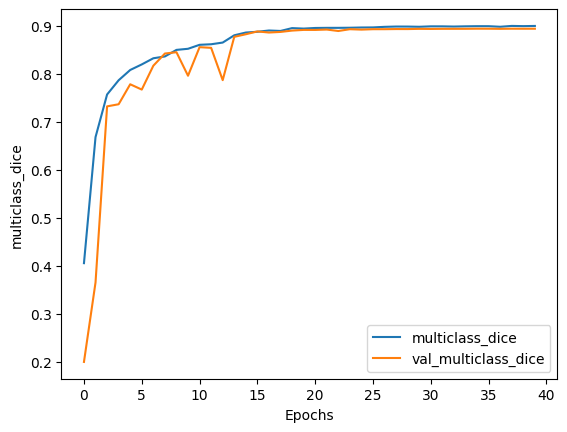

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "multiclass_dice")

# Calculating Subject-based Validation - Different approach from the original study

In [ ]:
import json, codecs

def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4)

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [ ]:
f = h5py.File("subject_based_dataset.hdf5", "r")

In [ ]:
frames2ched = f["train 2ch ED frames"][:,:,:,:]
masks2ched = f["train 2ch ED masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ched, masks2ched, random_state=42)

In [ ]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)

earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

model_laddernet.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

history = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=8,
                    epochs=30,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/30


2023-05-19 14:33:27.918864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 [==============================] - 56s 575ms/step - loss: 0.9090 - multiclass_dice: 0.3816 - accuracy: 0.7346 - val_loss: 6531387.5000 - val_multiclass_dice: 0.1734 - val_accuracy: 0.1107 - lr: 0.0010
Epoch 2/30
43/43 [==============================] - 23s 536ms/step - loss: 0.4404 - multiclass_dice: 0.6339 - accuracy: 0.8672 - val_loss: 7506.4458 - val_multiclass_dice: 0.1766 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 3/30
43/43 [==============================] - 24s 565ms/step - loss: 0.3356 - multiclass_dice: 0.7090 - accuracy: 0.8914 - val_loss: 119.7828 - val_multiclass_dice: 0.2534 - val_accuracy: 0.1789 - lr: 0.0010
Epoch 4/30
43/43 [==============================] - 24s 563ms/step - loss: 0.2891 - multiclass_dice: 0.7391 - accuracy: 0.9019 - val_loss: 35.1722 - val_multiclass_dice: 0.3322 - val_accuracy: 0.3907 - lr: 0.0010
Epoch 5/30
43/43 [==============================] - 24s 563ms/step - loss: 0.2624 - multiclass_dice: 0.7558 - accuracy: 0.9075 - val_loss: 21.7964 - va

1/1 [==============================] - 0s 26ms/step


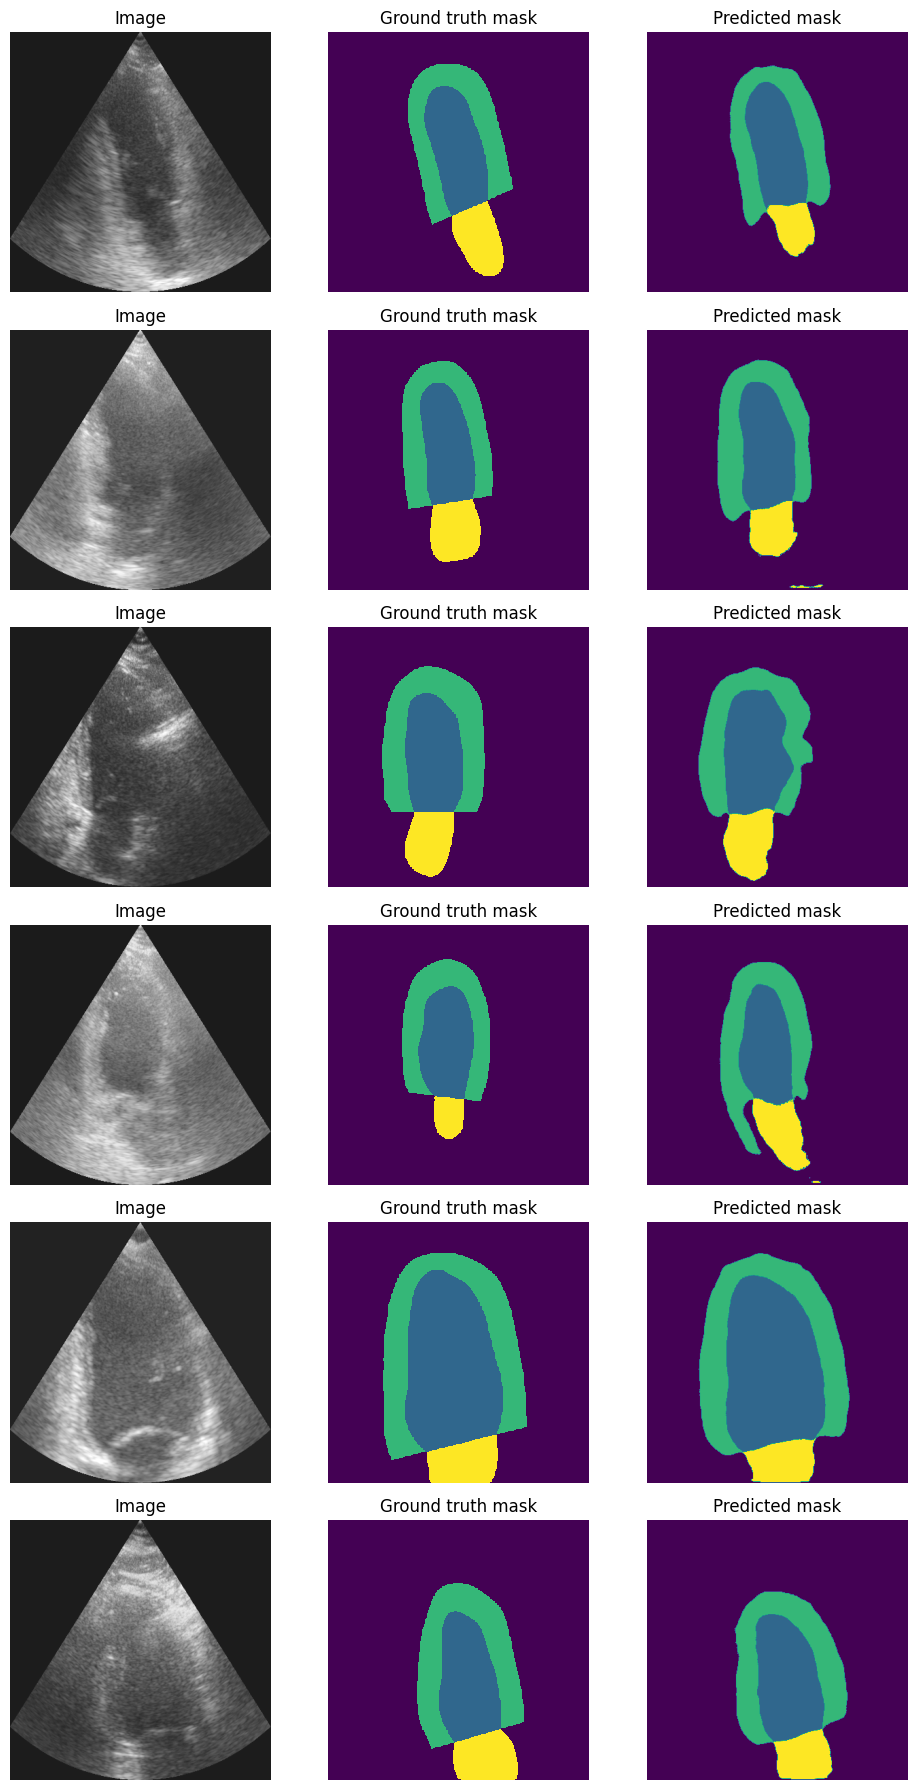

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("2chED.png")

    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

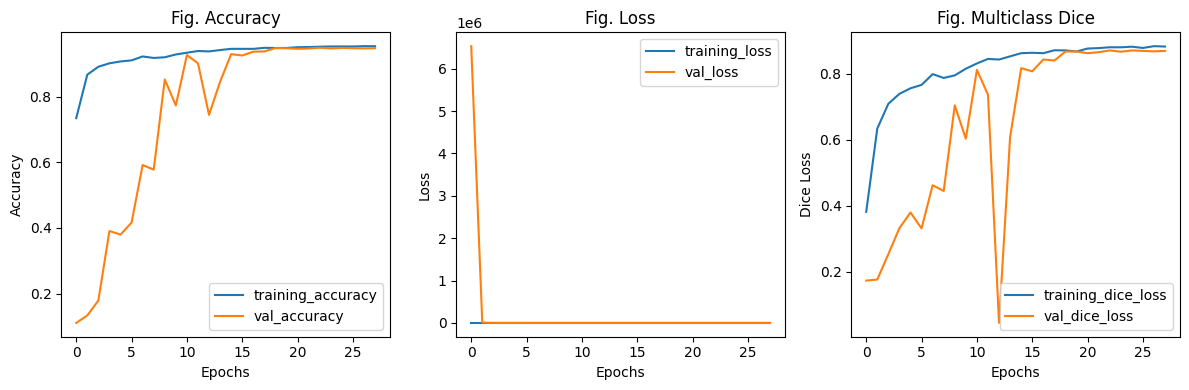

In [ ]:
cols = 3
rows = 1
figure, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))

ax1.plot(history.history["accuracy"])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["training_accuracy", 'val_accuracy'])

ax2.plot(history.history["loss"])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["training_loss", 'val_loss'])

ax3.plot(history.history["multiclass_dice"])
ax3.plot(history.history['val_multiclass_dice'])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Dice Loss")
ax3.legend(["training_dice_loss",'val_dice_loss'])

ax1.set_title("Fig. Accuracy")
ax2.set_title("Fig. Loss")
ax3.set_title("Fig. Multiclass Dice")
#ax1.set_axis_off()
#ax2.set_axis_off()
#ax3.set_axis_off()
plt.tight_layout()
plt.savefig("history1.png")
plt.show()

----

In [ ]:
frames2ches = f["train 2ch ES frames"][:,:,:,:]
masks2ches = f["train 2ch ES masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ches, masks2ches, random_state=42)

In [ ]:
history2 = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=8,
                    epochs=30,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/30
43/43 [==============================] - 23s 542ms/step - loss: 0.1774 - multiclass_dice: 0.8109 - accuracy: 0.9363 - val_loss: 0.1419 - val_multiclass_dice: 0.8449 - val_accuracy: 0.9453 - lr: 1.0000e-05
Epoch 2/30
43/43 [==============================] - 23s 534ms/step - loss: 0.1549 - multiclass_dice: 0.8342 - accuracy: 0.9434 - val_loss: 0.1379 - val_multiclass_dice: 0.8523 - val_accuracy: 0.9478 - lr: 1.0000e-05
Epoch 3/30
43/43 [==============================] - 24s 563ms/step - loss: 0.1475 - multiclass_dice: 0.8445 - accuracy: 0.9459 - val_loss: 0.1368 - val_multiclass_dice: 0.8556 - val_accuracy: 0.9487 - lr: 1.0000e-05
Epoch 4/30
43/43 [==============================] - 23s 532ms/step - loss: 0.1433 - multiclass_dice: 0.8487 - accuracy: 0.9471 - val_loss: 0.1400 - val_multiclass_dice: 0.8553 - val_accuracy: 0.9480 - lr: 1.0000e-05
Epoch 5/30
43/43 [==============================] - 24s 563ms/step - loss: 0.1401 - multiclass_dice: 0.8511 - accuracy: 0.9479 - val_los

1/1 [==============================] - 0s 30ms/step


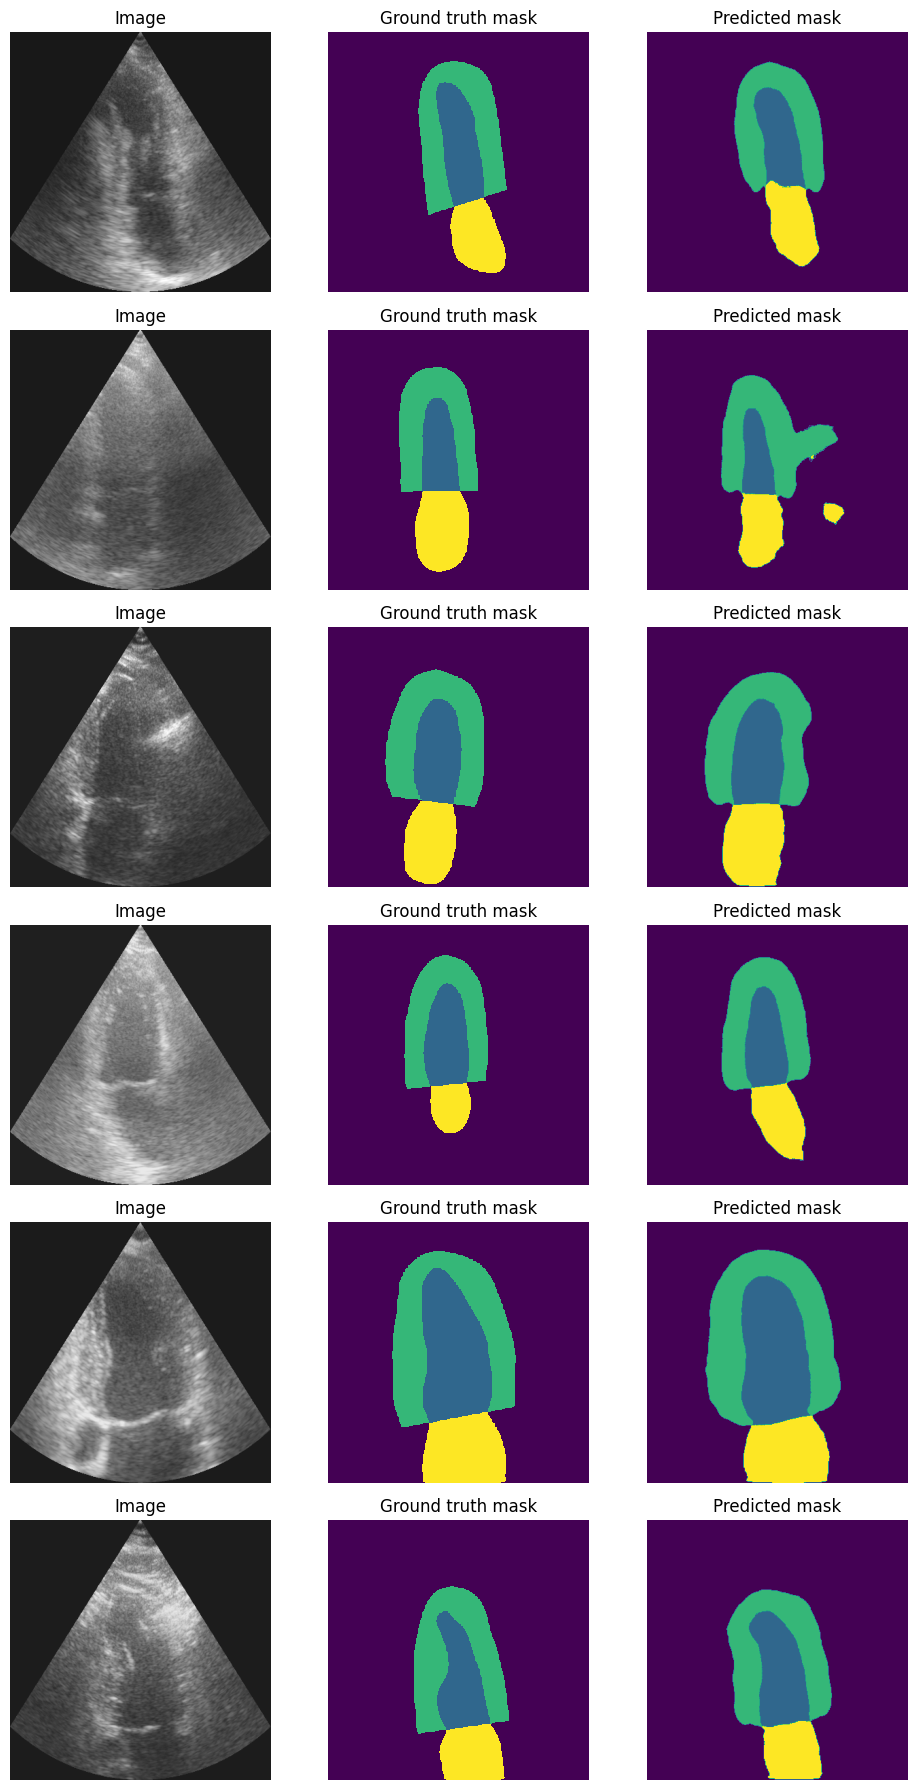

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("2chES.png")

    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

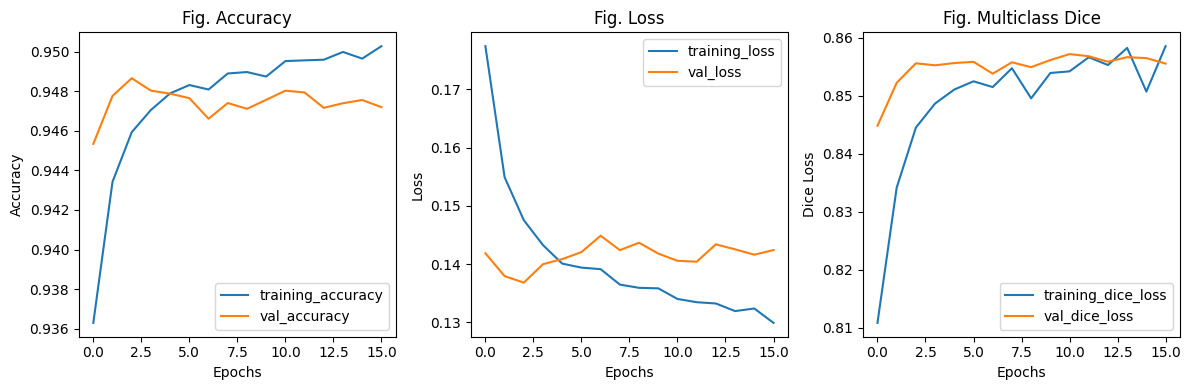

In [ ]:
cols = 3
rows = 1
figure, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))

ax1.plot(history2.history["accuracy"])
ax1.plot(history2.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["training_accuracy", 'val_accuracy'])

ax2.plot(history2.history["loss"])
ax2.plot(history2.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["training_loss", 'val_loss'])

ax3.plot(history2.history["multiclass_dice"])
ax3.plot(history2.history['val_multiclass_dice'])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Dice Loss")
ax3.legend(["training_dice_loss",'val_dice_loss'])

ax1.set_title("Fig. Accuracy")
ax2.set_title("Fig. Loss")
ax3.set_title("Fig. Multiclass Dice")
#ax1.set_axis_off()
#ax2.set_axis_off()
#ax3.set_axis_off()
plt.tight_layout()
plt.savefig("history2.png")
plt.show()

----

In [ ]:
frames4ched = f["train 4ch ED frames"][:,:,:,:]
masks4ched = f["train 4ch ED masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames4ched, masks4ched, random_state=42)

In [ ]:
history3 = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=8,
                    epochs=30,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/30
43/43 [==============================] - 23s 540ms/step - loss: 0.1895 - multiclass_dice: 0.8035 - accuracy: 0.9294 - val_loss: 0.1502 - val_multiclass_dice: 0.8433 - val_accuracy: 0.9437 - lr: 1.0000e-05
Epoch 2/30
43/43 [==============================] - 24s 563ms/step - loss: 0.1510 - multiclass_dice: 0.8390 - accuracy: 0.9418 - val_loss: 0.1404 - val_multiclass_dice: 0.8535 - val_accuracy: 0.9473 - lr: 1.0000e-05
Epoch 3/30
43/43 [==============================] - 23s 535ms/step - loss: 0.1389 - multiclass_dice: 0.8533 - accuracy: 0.9464 - val_loss: 0.1347 - val_multiclass_dice: 0.8593 - val_accuracy: 0.9494 - lr: 1.0000e-05
Epoch 4/30
43/43 [==============================] - 23s 536ms/step - loss: 0.1314 - multiclass_dice: 0.8580 - accuracy: 0.9491 - val_loss: 0.1301 - val_multiclass_dice: 0.8639 - val_accuracy: 0.9511 - lr: 1.0000e-05
Epoch 5/30
43/43 [==============================] - 23s 534ms/step - loss: 0.1281 - multiclass_dice: 0.8626 - accuracy: 0.9502 - val_los

1/1 [==============================] - 0s 27ms/step


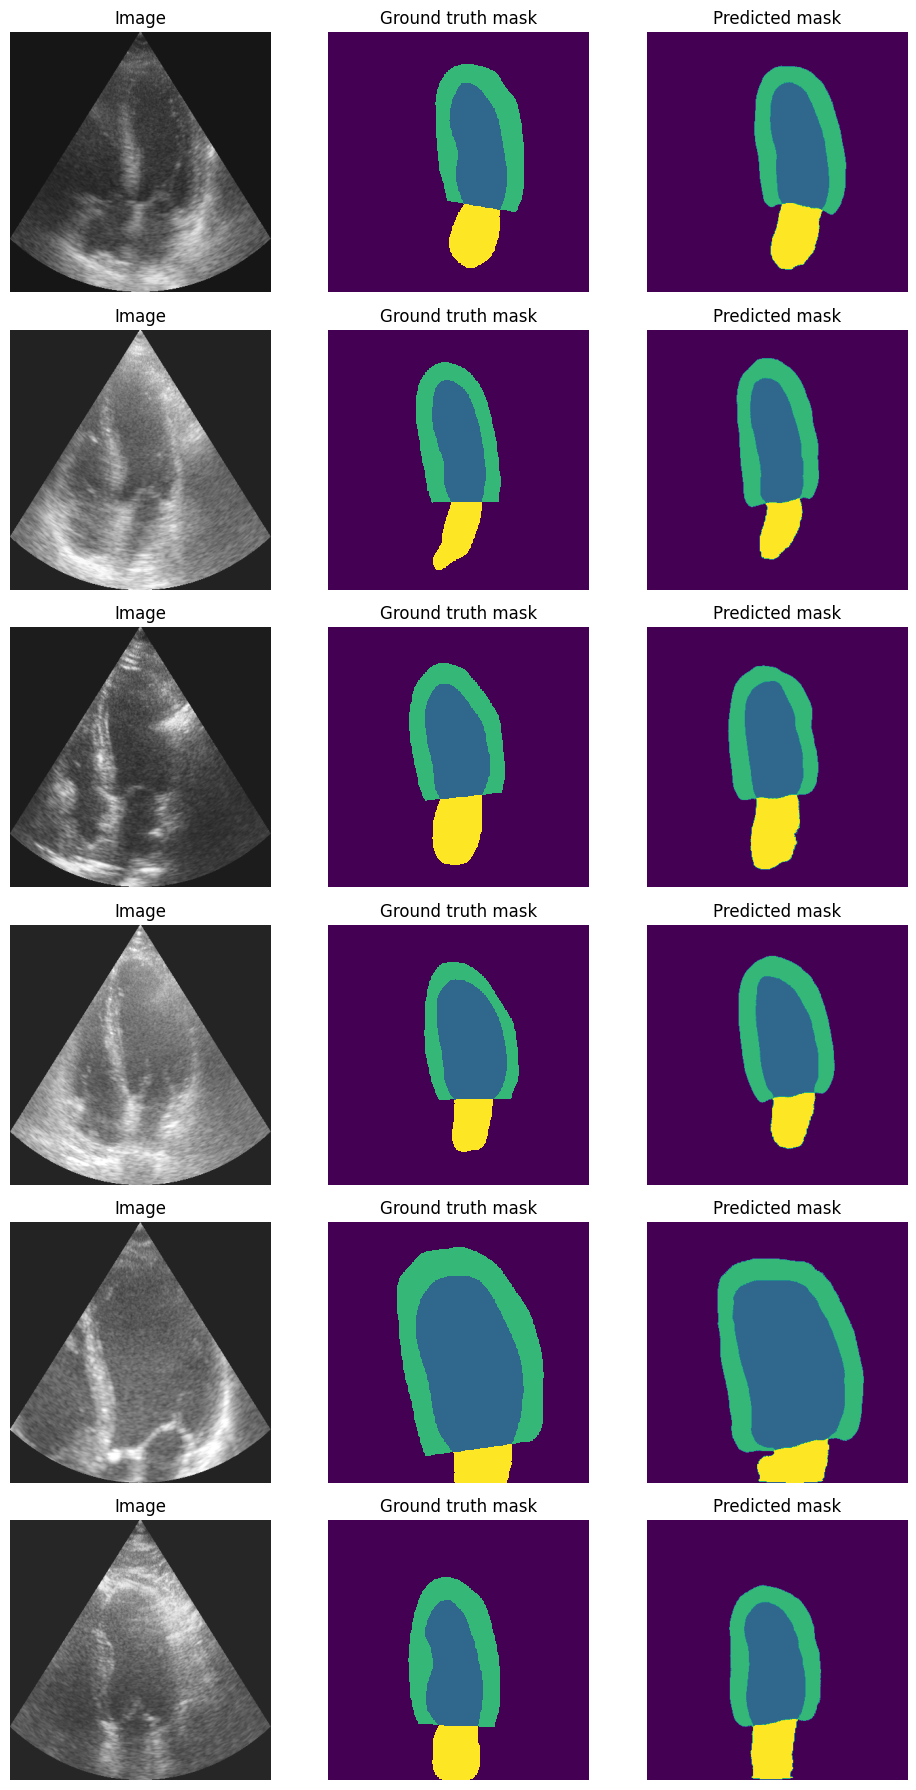

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("4chED.png")
    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

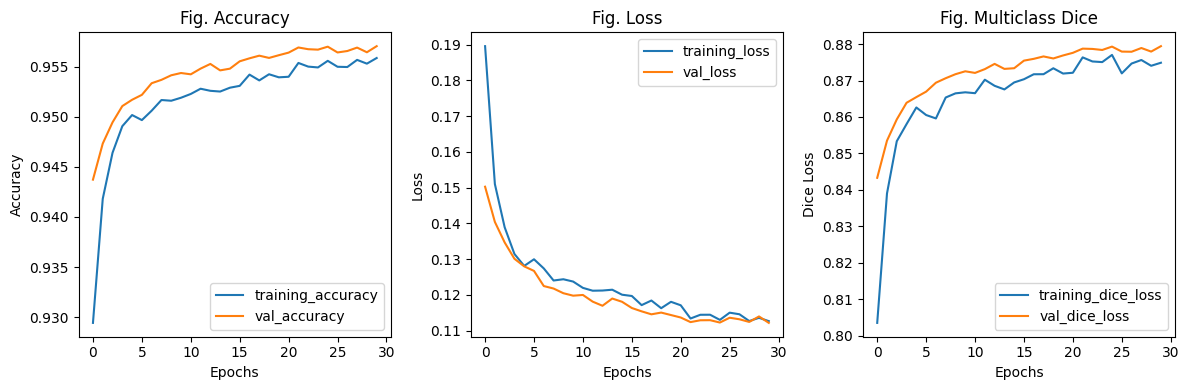

In [ ]:
cols = 3
rows = 1
figure, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))

ax1.plot(history3.history["accuracy"])
ax1.plot(history3.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["training_accuracy", 'val_accuracy'])

ax2.plot(history3.history["loss"])
ax2.plot(history3.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["training_loss", 'val_loss'])

ax3.plot(history3.history["multiclass_dice"])
ax3.plot(history3.history['val_multiclass_dice'])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Dice Loss")
ax3.legend(["training_dice_loss",'val_dice_loss'])

ax1.set_title("Fig. Accuracy")
ax2.set_title("Fig. Loss")
ax3.set_title("Fig. Multiclass Dice")
#ax1.set_axis_off()
#ax2.set_axis_off()
#ax3.set_axis_off()
plt.tight_layout()
plt.savefig("history3.png")
plt.show()

----

In [ ]:
frames4ches = f["train 4ch ES frames"][:,:,:,:]
masks4ches = f["train 4ch ES masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames4ches, masks4ches, random_state=42)

In [ ]:
history4 = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=8,
                    epochs=30,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/30
43/43 [==============================] - 23s 541ms/step - loss: 0.1520 - multiclass_dice: 0.8252 - accuracy: 0.9450 - val_loss: 0.1263 - val_multiclass_dice: 0.8455 - val_accuracy: 0.9516 - lr: 1.0000e-05
Epoch 2/30
43/43 [==============================] - 24s 563ms/step - loss: 0.1310 - multiclass_dice: 0.8498 - accuracy: 0.9516 - val_loss: 0.1221 - val_multiclass_dice: 0.8562 - val_accuracy: 0.9537 - lr: 1.0000e-05
Epoch 3/30
43/43 [==============================] - 24s 563ms/step - loss: 0.1275 - multiclass_dice: 0.8549 - accuracy: 0.9529 - val_loss: 0.1220 - val_multiclass_dice: 0.8585 - val_accuracy: 0.9541 - lr: 1.0000e-05
Epoch 4/30
43/43 [==============================] - 23s 534ms/step - loss: 0.1251 - multiclass_dice: 0.8565 - accuracy: 0.9535 - val_loss: 0.1210 - val_multiclass_dice: 0.8609 - val_accuracy: 0.9548 - lr: 1.0000e-05
Epoch 5/30
43/43 [==============================] - 23s 536ms/step - loss: 0.1230 - multiclass_dice: 0.8602 - accuracy: 0.9540 - val_los

1/1 [==============================] - 0s 38ms/step


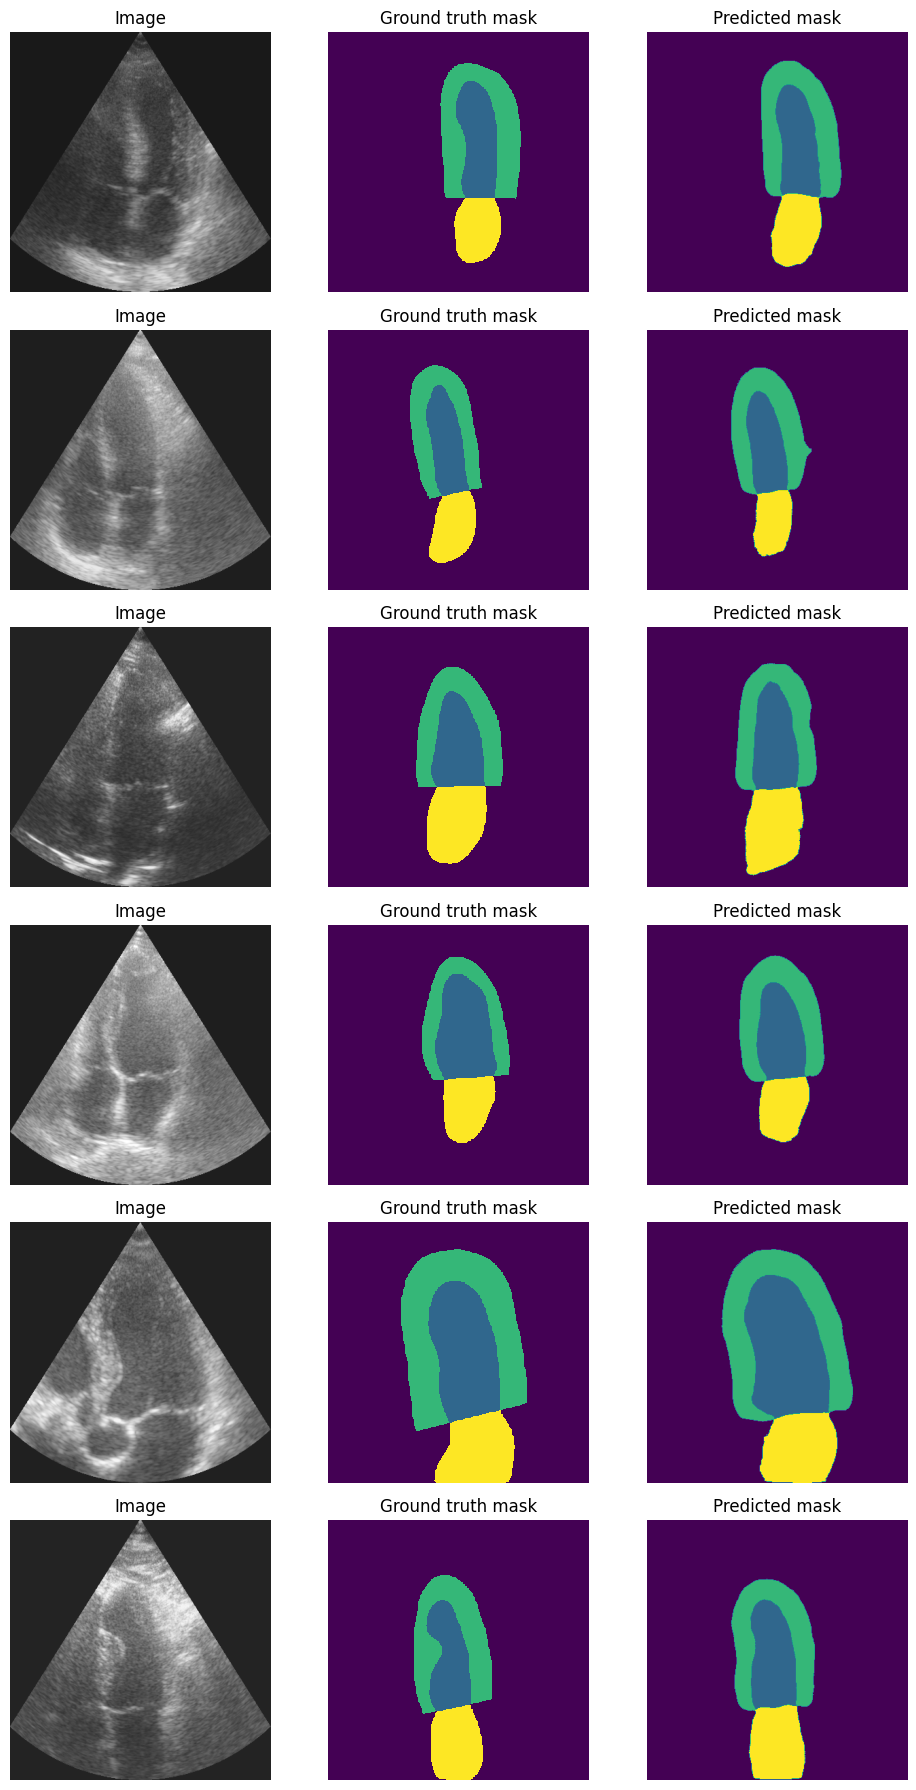

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("4chES.png")
    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

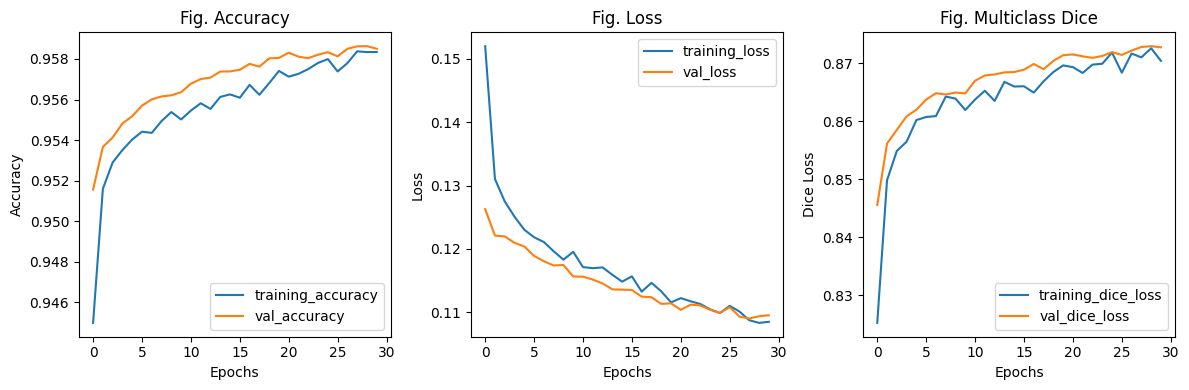

In [ ]:
cols = 3
rows = 1
figure, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))

ax1.plot(history4.history["accuracy"])
ax1.plot(history4.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["training_accuracy", 'val_accuracy'])

ax2.plot(history4.history["loss"])
ax2.plot(history4.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["training_loss", 'val_loss'])

ax3.plot(history4.history["multiclass_dice"])
ax3.plot(history4.history['val_multiclass_dice'])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Dice Loss")
ax3.legend(["training_dice_loss",'val_dice_loss'])

ax1.set_title("Fig. Accuracy")
ax2.set_title("Fig. Loss")
ax3.set_title("Fig. Multiclass Dice")
#ax1.set_axis_off()
#ax2.set_axis_off()
#ax3.set_axis_off()
plt.tight_layout()
plt.savefig("history4.png")
plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'multiclass_dice', 'accuracy', 'val_loss', 'val_multiclass_dice', 'val_accuracy', 'lr'])


In [ ]:
all_accuracy=np.concatenate((history.history['accuracy'],history2.history['accuracy'], history3.history['accuracy'], history4.history['accuracy']),axis=0)
all_val_accuracy=np.concatenate((history.history['val_accuracy'], history2.history['val_accuracy'], history3.history['val_accuracy'], history4.history['val_accuracy']),axis=0)
all_loss=np.concatenate((history.history['loss'],history2.history['loss'], history3.history['loss'],history4.history['loss']),axis=0)
all_val_loss=np.concatenate((history.history['val_loss'],history2.history['val_loss'], history3.history['val_loss'],history4.history['val_loss']),axis=0)
all_diceloss=np.concatenate((history.history['multiclass_dice'],history2.history['multiclass_dice'], history3.history['multiclass_dice'],history4.history['multiclass_dice']),axis=0)
all_val_diceloss=np.concatenate((history.history['val_multiclass_dice'],history2.history['val_multiclass_dice'], history3.history['val_multiclass_dice'],history4.history['val_multiclass_dice']),axis=0)

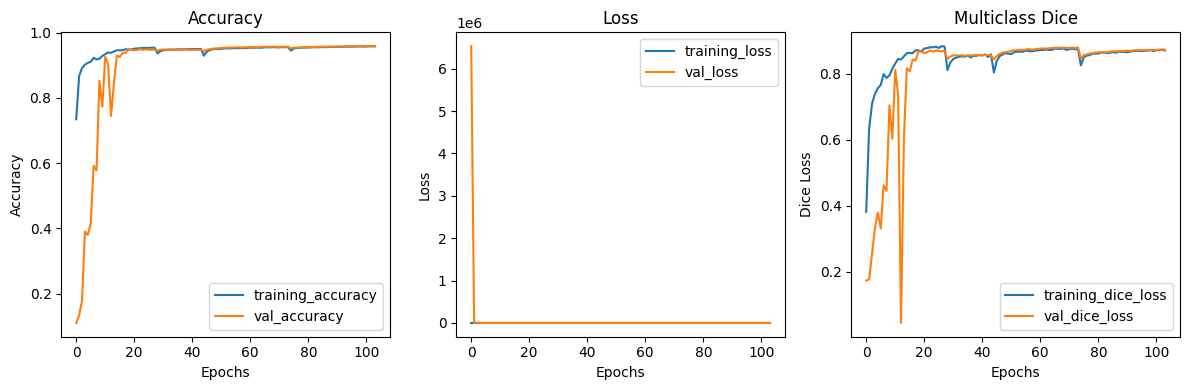

In [ ]:
cols = 3
rows = 1
figure, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))

ax1.plot(all_accuracy)
ax1.plot(all_val_accuracy)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["training_accuracy", 'val_accuracy'])

ax2.plot(all_loss)
ax2.plot(all_val_loss)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["training_loss", 'val_loss'])

ax3.plot(all_diceloss)
ax3.plot(all_val_diceloss)
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Dice Loss")
ax3.legend(["training_dice_loss",'val_dice_loss'])

ax1.set_title("Accuracy")
ax2.set_title("Loss")
ax3.set_title("Multiclass Dice")
#ax1.set_axis_off()
#ax2.set_axis_off()
#ax3.set_axis_off()
plt.tight_layout()
plt.savefig("history_all.png")
plt.show()

In [ ]:
frames2ched = f["train 2ch ED frames"][:,:,:,:]
masks2ched = f["train 2ch ED masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ched, masks2ched, random_state=42)

1/1 [==============================] - 0s 28ms/step


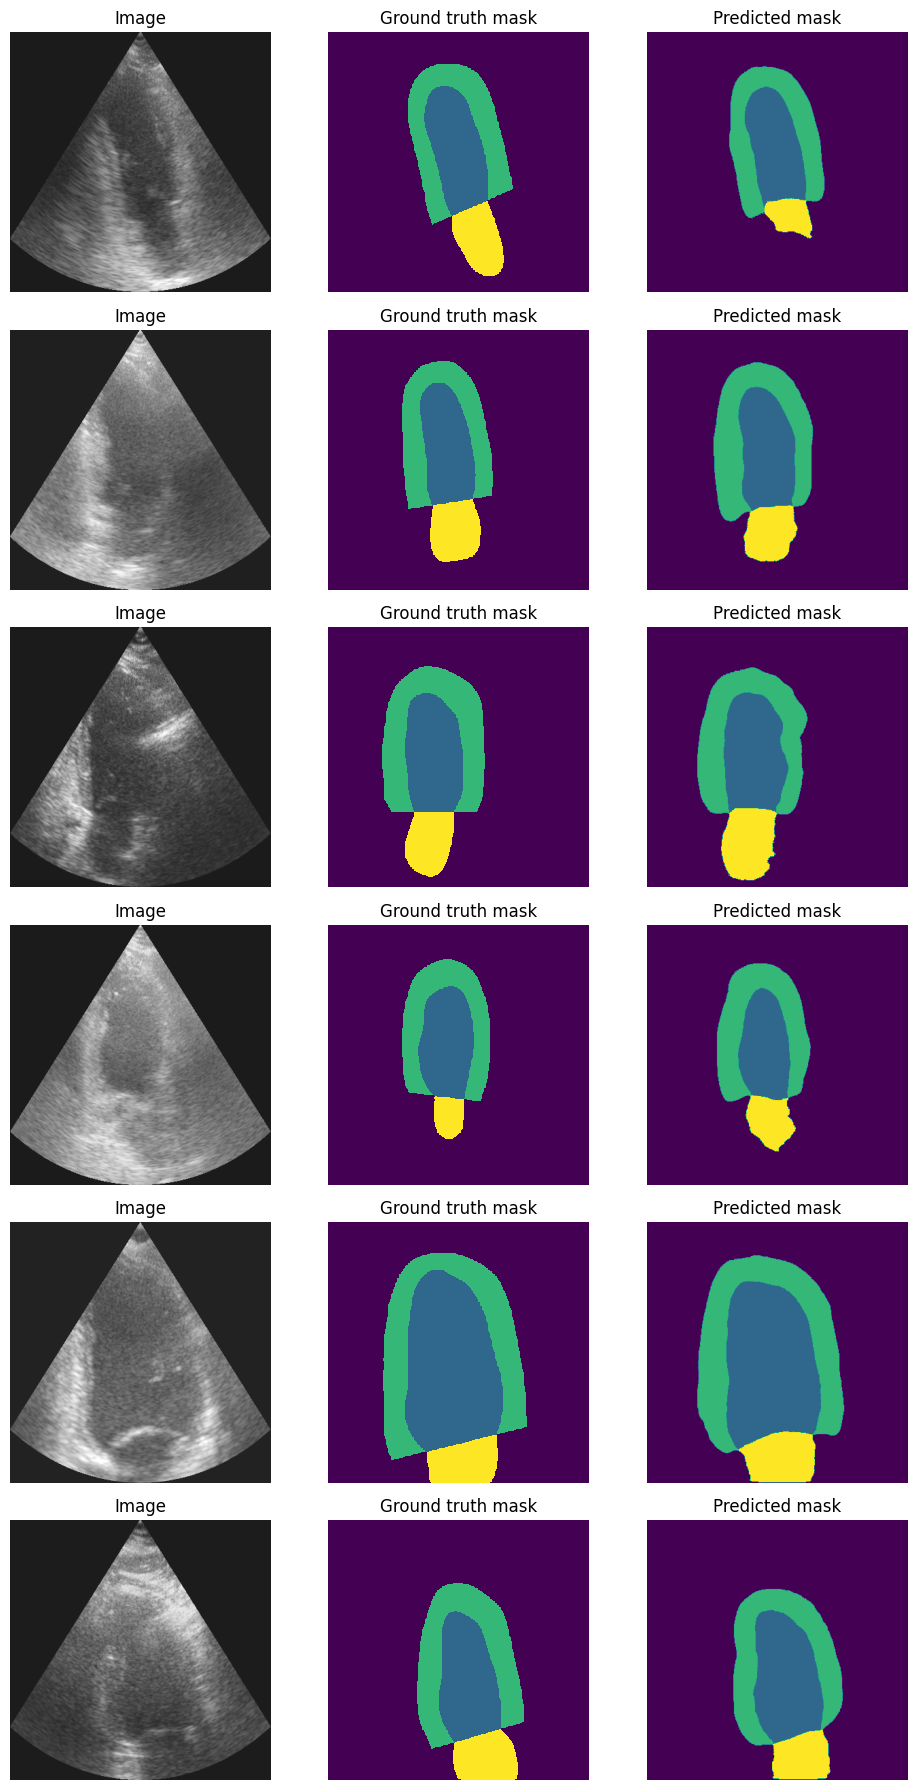

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("2chED_AfterAllTrain.png")

    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

In [ ]:
frames2ches = f["train 2ch ES frames"][:,:,:,:]
masks2ches = f["train 2ch ES masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ches, masks2ches, random_state=42)

1/1 [==============================] - 0s 27ms/step


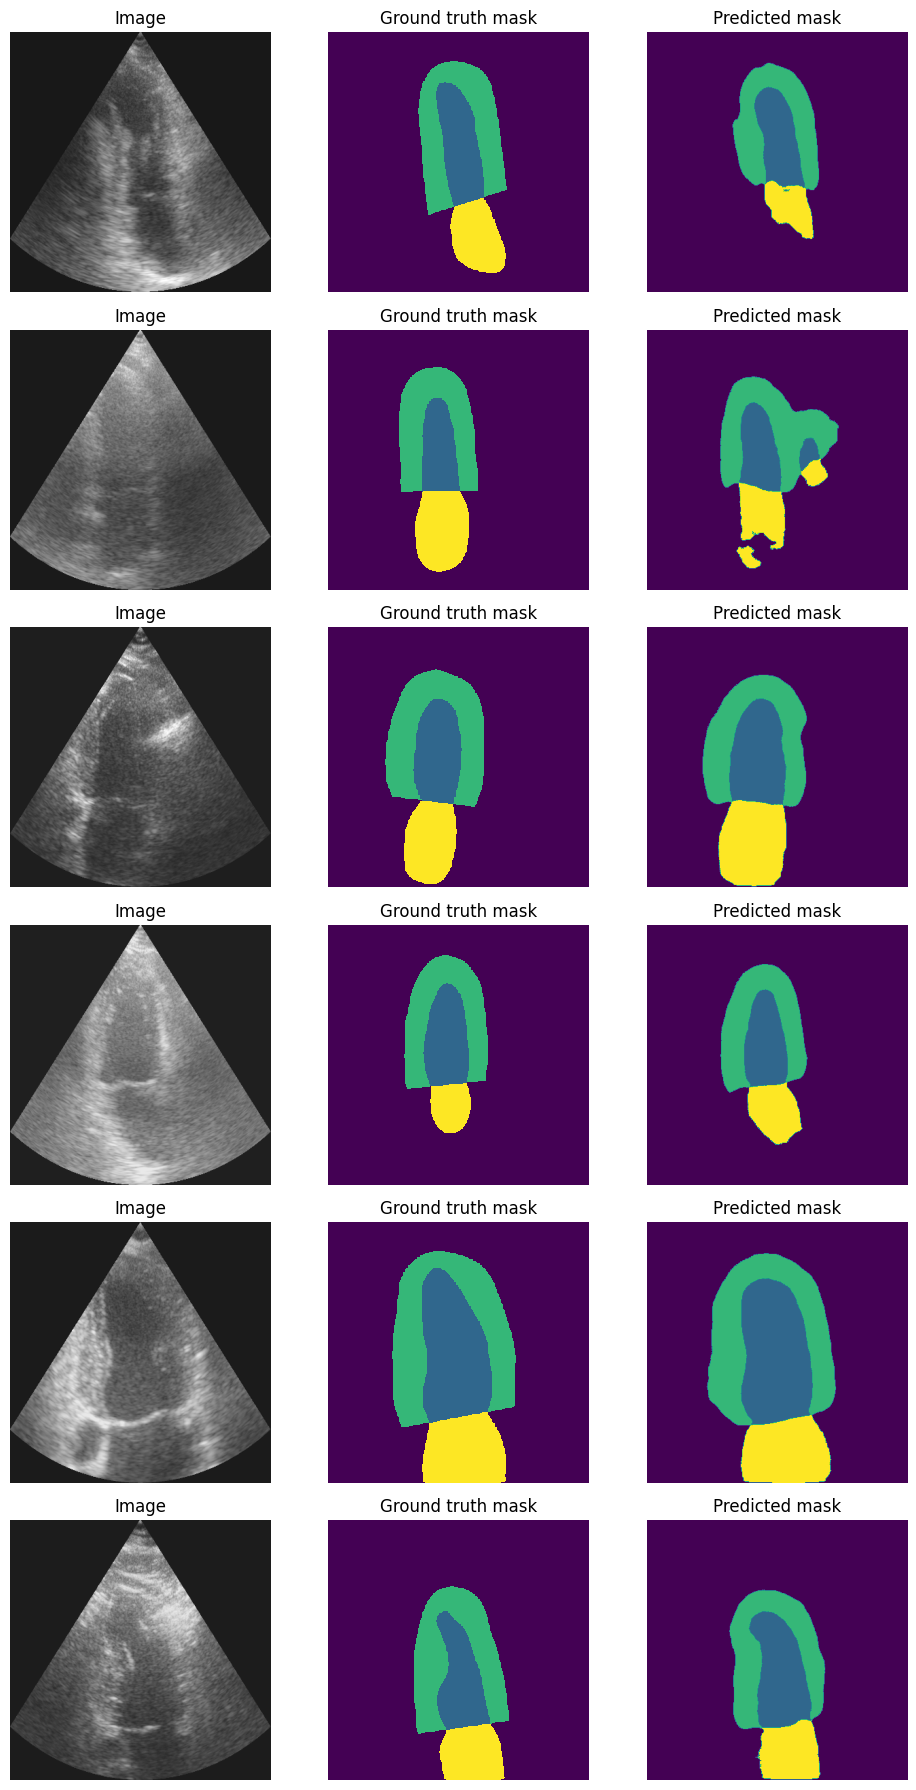

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("2chES_AfterAllTrain.png")
    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

In [ ]:
frames4ched = f["train 4ch ED frames"][:,:,:,:]
masks4ched = f["train 4ch ED masks"][:,:,:,:]
train_frames, test_frames, train_masks, test_masks = train_test_split(frames4ched, masks4ched, random_state=42)

1/1 [==============================] - 0s 27ms/step


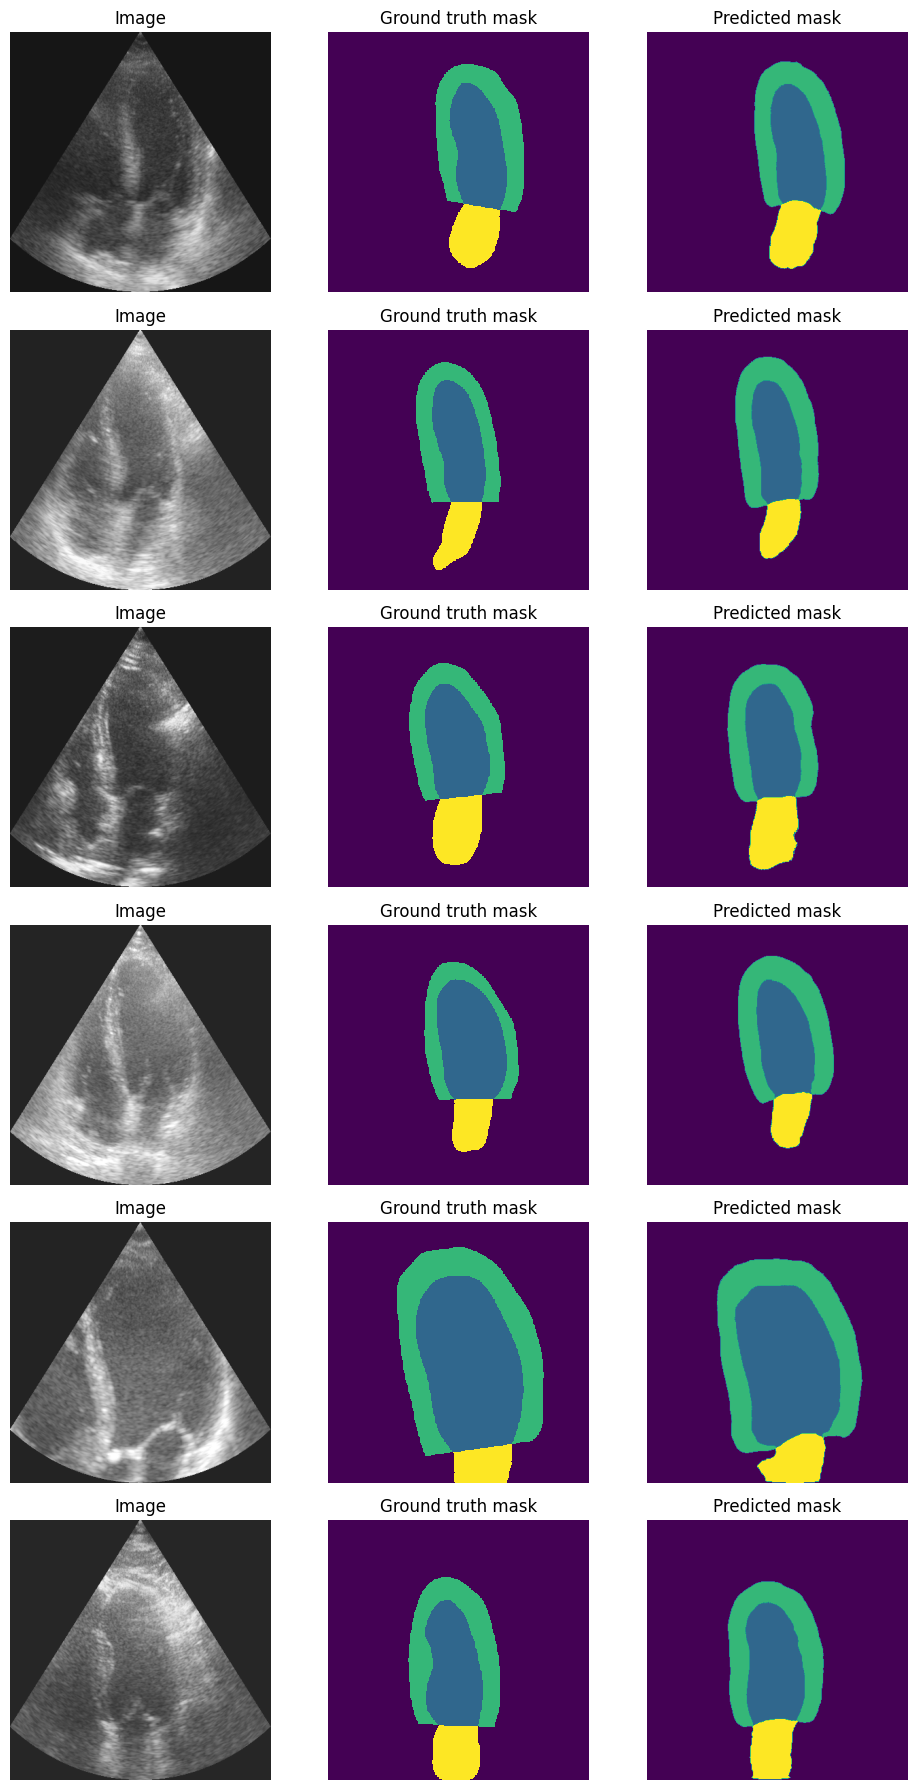

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 6
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 18))
    for i in range(6):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.savefig("4chED_AfterAllTrain.png")
    plt.show()


predicted_masks = []
for i in range(6):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))
display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)